In [1]:
#install pint if needed
try:
    from pint import UnitRegistry
except ImportError:
    %pip install pint
    
# import units
from pint import UnitRegistry
units = UnitRegistry()

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

In [3]:
# import functions from modsim

from modsim import *

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

For this example we will be using a AJ-60A booster from the Atlas V.

Assumptions:
- drag coefficient is the same as a baseball
- earth is a perfect circle 12,756 km in diameter (~equatorial diameter)
- thrust is constant

TODO:
- figure out angle jankness
    - still moving sideways some when pointing stright up
    - graphs just look wrong for pitch over
    - pitch over is instantaneous
- make more graphs
    - a, forces, rho
- finish making earth round
    - figure out calcs for gravity
        - proper height calculation
        - face toward center of earth
    - figure out drag calc
        - proper height calculation
    - anything else that expects Y to be distance above earth
    - turn the thrust of the ship?


Pitch over happens at 244m, for this simulation we'll say the angle change instantaneously from 90 degrees (vertical) to 45 degrees. In the future a more complicated approach will be used. [This article](https://globaljournals.org/GJSFR_Volume12/6-Computational-Algorithm-for-Gravity.pdf) explains more of the math behind pitch over.

In [4]:
# Set up params, all metric
params = Params(
    x = 0,
    speed = 0,

    g0 = 9.8,        # m/s**2
    Re = 6371000,

    t_end = 200,     # s

    C_d = 1.82, # of a baseball

    turnover_time = 2244.0,
    turnover_angle = 45.0,

    earth_diameter = 12756000, # meters

    #booster AJ-60A from an Atlas V
    max_thrust = 1688400.0, #N
    specific_impulse = 279.3, #s; need to figure out how to use this
    diameter = 	1.6,
    mass = 	46697.0,
    propellent_mass = 42630.0,
    burn_time = 94.0,
)

In [5]:
from gravity import calc_gravity
print(calc_gravity(Vector(0,0), params))
print(calc_gravity(Vector(100000, 0), params))

x    0.0
y    0.0
Name: component, dtype: float64
x   -45991.268563
y       -0.000000
Name: component, dtype: float64


In [6]:
from numpy import pi, deg2rad
from turnover import calc_angle

def make_system(params):
    y = params.earth_diameter / 2

    # convert angle to radians
    angle = calc_angle(y, params)
    theta = deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, params.speed)
    
    # make the initial state
    G = calc_gravity(Vector(params.x, y), params)
    mass = params.mass
    
    init = State(x=params.x, y=y, vx=vx, vy=vy)
    
    # compute the frontal area
    area = pi * (params.diameter/2)**2

    return System(params,
                  init = init,
                  area = area)

In [7]:
system = make_system(params)
show(system.init)

,state
x,0.0
y,6378000.0
vx,0.0
vy,0.0


The drag force is dependant on the density of the air. Which depends on the altitude, temperature, and pressure. To simplify this we will be use values from [this table](https://www.engineeringtoolbox.com/standard-atmosphere-d_604.html). In the future we might enhance this, perhaps evening pulling real temp and pressure data from somewhere online. [This](https://www.grc.nasa.gov/www/k-12/airplane/atmosmet.html) NASA article explains the math some more.

In [8]:
from drag import drag_force
print(drag_force(Vector(10, 10), 0, system))

x   -348.540968
y   -348.540968
Name: component, dtype: float64


In [9]:
from thrust import thrust_force
print(thrust_force(5, 0, system))
print(thrust_force(500, 0, system))

x    1.033847e-10
y    1.688400e+06
Name: component, dtype: float64
x    0.0
y    0.0
Name: component, dtype: float64


In [10]:
from mass import calc_mass
print(calc_mass(0, system))
print(calc_mass(system.burn_time / 2, system))
print(calc_mass(system.burn_time * 2, system))

46697.0
25382.0
4067.0


In [11]:
def calculate_all(t, x, y, vx, vy):
    V = Vector(vx, vy)
    P = Vector (x, y)

    mass = calc_mass(t, system)

    f_drag = drag_force(V, P, system)
    a_drag = f_drag / mass

    f_thrust = thrust_force(t, y, system)
    a_thrust = f_thrust / mass
    
    G = calc_gravity(P, system)
    A = G + a_drag + a_thrust

    return Params(
        acceleration = Params(
            total = A,
            gravity = G,
            drag = a_drag,
            trust = a_thrust,
        ),
        mass = mass,
        forces = Params(
            drag = f_drag,
            trust = f_thrust
        )
    )


def slope_func(t, state, system):
    x, y, vx, vy = state

    calculations = calculate_all(t, x, y, vx, vy)
    A = calculations.acceleration.total
    
    return vx, vy, A.x, A.y

In [12]:
slope_func(0, system.init, system)

(0.0, 0.0, 25.56650511500454, 15.766505115004538)

In [13]:
def event_func(t, state, system):
    x, y, vx, vy = state
    return y if t > 0 else 1

In [14]:
event_func(0, system.init, system)

1

In [15]:
results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)
details.message

'The solver successfully reached the end of the integration interval.'

In [16]:
flight_time = results.index[-1]
flight_time

200.0

701368.5927276564
6932049.1282585235
0.0
6378000.0


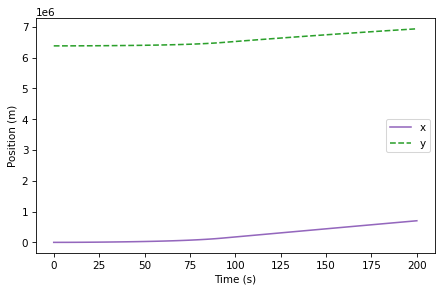

In [17]:
results.x.plot(color='C4')
results.y.plot(color='C2', style='--')

print(results.x.max())
print(results.y.max())
print(results.x.min())
print(results.y.min())

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

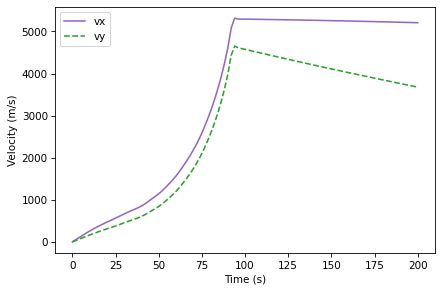

In [18]:
results.vx.plot(color='C4')
results.vy.plot(color='C2', style='--')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

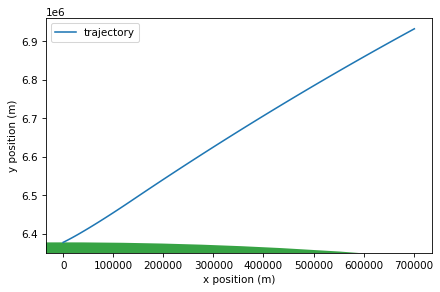

In [19]:
def plot_trajectory(results):
    x = results.x
    y = results.y
    make_series(x, y).plot(label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')
    
    ax = plt.gca()
    pp2 = plt.Circle((0, 0), params.earth_diameter / 2)
    pp2.set_facecolor('#37a344')
    ax.add_patch(pp2)
    
    

plot_trajectory(results)

In [20]:
more_results = {
    'ax': pd.Series(), 
    'ay': pd.Series(), 
    'gx': pd.Series(), 
    'gy': pd.Series(), 
    'tx': pd.Series(), 
    'ty': pd.Series(), 
    'mass': pd.Series()
    }

for t in results.x.index:
    calculations = calculate_all(t, results.x[t], results.y[t], results.vx[t], results.vy[t])
    more_results['ax'][t] = calculations.acceleration.total.x
    more_results['ay'][t] = calculations.acceleration.total.y
    more_results['gx'][t] = calculations.acceleration.gravity.x
    more_results['gy'][t] = calculations.acceleration.gravity.y
    more_results['tx'][t] = calculations.acceleration.trust.x
    more_results['ty'][t] = calculations.acceleration.trust.y
    more_results['mass'][t] = calculations.mass

more_df = pd.DataFrame(data=more_results)

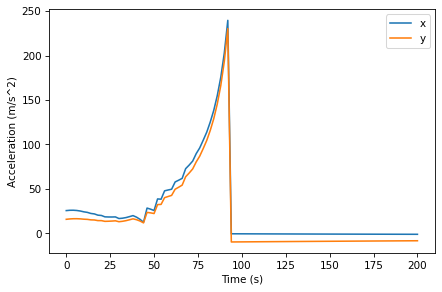

In [21]:
more_df.ax.plot(label='x')
more_df.ay.plot(label='y')

decorate(xlabel='Time (s)',
            ylabel='Acceleration (m/s^2)')

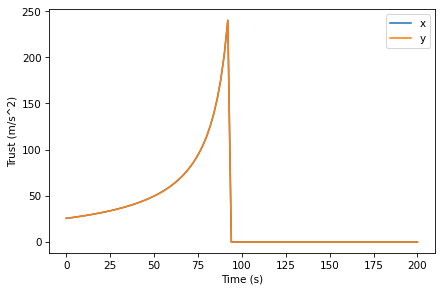

In [28]:
more_df.tx.plot(label='x')
more_df.ty.plot(label='y')

decorate(xlabel='Time (s)',
            ylabel='Trust (m/s^2)')

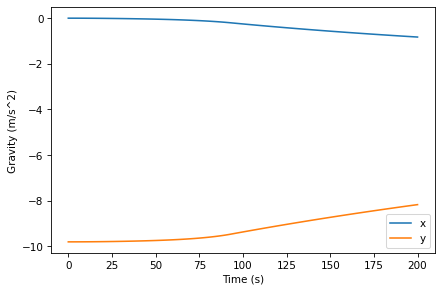

In [23]:
more_df.gx.plot(label='x')
more_df.gy.plot(label='y')

decorate(xlabel='Time (s)',
            ylabel='Gravity (m/s^2)')

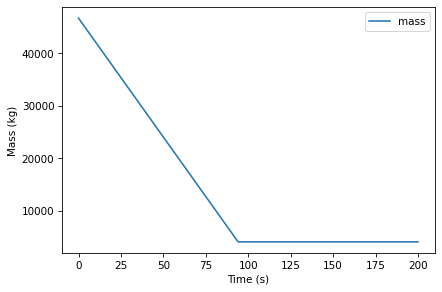

In [24]:
more_df.mass.plot(label='mass')

decorate(xlabel='Time (s)',
            ylabel='Mass (kg)')

In [25]:
from matplotlib.pyplot import plot

xlim = results.x.min(), results.x.max()
ylim = results.y.min(), results.y.max()

def draw_func(t, state):
    plot(state.x, state.y, 'bo')
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=xlim,
             ylim=ylim)

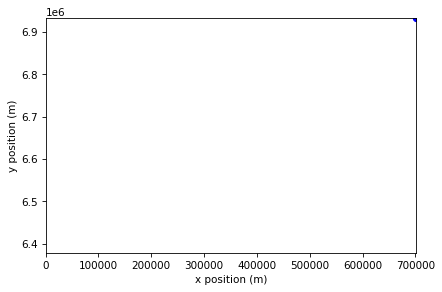

In [26]:
animate(results, draw_func)